### <p style="text-align: right;"> &#9989; Nathan Kurt</p>

# __CMSE  201 - Fall 2018__
     
<img src="https://cmse.msu.edu/_cmse/assets/Image/CMSE-bigger.png"
     alt="CMSE Grapical Image"
     align="right" 
     height="82" 
     width="82" />

# Homework 6: Molecular Dynamics of 2D particles

## Goals

### By the end of the homework assignment you will have:

1. Practiced reading and using pre-existing code to solve complex problems.
2. Run physical simulations of interacting particles 
3. Calculated averages of observable quantities
4. Implemented different interparticle forces
5. Visualized Langevin dynamics trajectories (which model the motion of molecules!)

## Assignment instructions

Work through the following assignment, making sure to follow all of the directions and answer all of the questions.

**This assignment is due at 11:59pm on Friday, November 30th.** It should be uploaded into the "Homework Assignments" submission folder for Homework #6.  Submission instructions can be found at the end of the notebook.

----
----
**IMPORTANT NOTE ABOUT THIS ASSIGNMENT (READ THIS!)**: This assignment deals with complex concepts and sosphicated math that is directly related to some of the research taking place here at MSU. **It is not expected that you completely understand all of the math involved in this assignment**. The goal is to read through the text and explore the mathematical equations to acquire as much understanding as you can about what is presented. Because the models in this assignment are complicated, much of the code is provided for you, but you should find that at this point in the semester you have all of the skills necessary to read, understand, and manipulate the code in order to run simulations that realistically model the motion of molecules!

----
----

## Grading

* One particle (**16 points**)
    - Running and visualizing a trajectory (3 points)
    - Descriptive analysis (3 points)
    - Running multiple trajectories (10 points) 
* Many particles with size exclusion (**14 points**)
    - Run three trajectories (3 points)
    - Visualize them (3 points)
    - Find closest interparticle distance (5 points)
    - Plot lowest distance (3 points)
* Attractive forces (**20 points**)
    - Plot $U_{LJ}$ (3 points)
    - Introduce attractive term (4 points)
    - Run a trajectory and describe (5 points)
    - Plot a histogram of interparticle distances (6 points)
    - Describe results (2 points)

    
**Total**: 50 points

---
## Introduction

### The math behind molecular dynamics

You have learned before about random walks, that can mimic purely diffusive processes in 1D, 2D or 3D.  You also learned about kinematics, where a particle can fly through space with a particular velocity, subject to forces such as gravity.  In *Langevin dynamics*, these two concepts are combined, where **particles still have velocity and momentum, but the motion is partly random**.

[Langevin dynamics](https://en.wikipedia.org/wiki/Langevin_dynamics) describes motion that is both directed and diffusive:

\begin{equation}
m\overrightarrow{a} = - \nabla U(\overrightarrow{x}) - \gamma m \overrightarrow{v} + \sqrt{2 \gamma k_B T m} \overrightarrow{R}(t)
\end{equation}

This equation might look intimidating, but it is really another version of $\overrightarrow{F} = m \overrightarrow{a}$, which is to say that the forces acting on an object are directly proportional to the mass and acceleration of that object.  
On the right hand side, there are three terms that describe the *force* on each particle.

* First, the $- \nabla U(\overrightarrow{x})$ a "potential energy" to determine a force.  **Let's set that aside for now and assume $U(\overrightarrow{x}) = 0$.**

* Second, there is the $-\gamma m \overrightarrow{v}$ term.  This is called a "drag" term.  It is a force that is opposite to the direction of motion.  The higher the velocity ($\overrightarrow{v}$), the greater the drag! Here, $m$ is the mass of each particle and $\gamma$ is the friction coefficient, which would be higher for more viscous fluids.

* Third, there is the $\sqrt{2 \gamma k_B T m} \overrightarrow{R}(t)$ term.  The important part is $\overrightarrow{R}(t)$, which is a random force that kicks the particles around.  This will involve random numbers that are chosen at each time step.  The $\sqrt{2 \gamma k_B T m}$ term controls the **strength** of these random kicks, where $k_BT$ is the **thermal energy**.  The higher the thermal energy, the bigger the kicks are.

***
So how do we use this to run trajectories?  First, let's review the equations that come from kinematics:

\begin{equation} \overrightarrow{x}(t+\Delta t) \approx \overrightarrow{x}(t) + \overrightarrow{v}(t) \Delta t \end{equation}

\begin{equation} \overrightarrow{v}(t+\Delta t) \approx \overrightarrow{v}(t) + \overrightarrow{a}(t) \Delta t \end{equation}

These tell us that the position of an object can be updated using information about its velocity and the velocity of an object can be updated using information about its acceleration.

We can then plug in our somewhat complicated expression from above for the acceleration ($\overrightarrow{a}$): 

\begin{equation} \overrightarrow{v}(t+\Delta t) \approx \overrightarrow{v}(t) + \Delta t \left(- \frac{1}{m}\nabla U(\overrightarrow{x}) - \gamma \overrightarrow{v} + \sqrt{\frac{2 \gamma k_B T}{m} } \overrightarrow{R}(t) \right) \end{equation}

OK, let's jump right in here!  First we'll define some constants we need for our model:

In [1]:
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt

# define our constants
m = 0.5      # the mass of our particles
kT = 10000.0     # thermal energy
gamma = 10.0  # friction coefficient
dt = 0.00002  # time step

Next, we define some functions that we'll use to update these variables, using the kinematic equations from above. **Make sure you see how the mathematical equations from above are reproduced in the functions below.** The first two functions should look very similar to the "update equations" that we've used in the past. The third function is a function for defining $\frac{dU}{dx}$, which is just 0 for now because we're assuming the potential energy is zero. The final function is the one that introduces randomness into our system (the $\overrightarrow{R}(t)$ function from above).

In [2]:
# functions for updating system coordinates

def updatepos(xold,vold,dt):
    # returns the new positions, using the old positions and the old velocities
    xnew = xold + vold*dt
    return xnew

def updatevel(xold,vold,dt,m,gamma,pref):
    # returns the new velocities, given the old acceleration
    # which is the sum of the external forces, a drag term, and a random force
    vnew = vold + dt*(-dUdx(xold)/m - gamma*vold + pref*rfunc(xold.shape))
    return vnew
    
def dUdx(xold):
    # let's forget about this for now and return an array of zeros
    f0 = np.array([0,0])
    return f0

def rfunc(shape):
    # return a vector with components chosen from a Gaussian distribution
    r = np.random.normal(size=shape)
    return r

OK, we're ready to go.  We when run our simulations, we'll also record the position in a variable called `traj` as you'll see below.  But we don't have to do this every time step!  To make it more manageable we'll do it every `save_int` time steps, which we define and set to 100 below.

---
## Part 1: One particle (16 points)

### Running and visualizing a trajectory (3 points)

We're going to simulate the motion of a single particle in two dimensions, so we'll need two numbers to store the position, and two more for the velocity.  We'll store these as numpy arrays:

In [3]:
x0 = np.array([0,0])    # initial position
v0 = np.array([1.0,1.0])    # initial velocity

N = 20000   # number of time steps
npart = 1    # number of particles

save_int = 100  # how often to save the position

Use the following function to run a single trajectory and store the positions in the `traj` variable.  Use a simple plotting command to visualize the trajectory and report what you observe. Remember that the "x" position is really a two element array of $x$ *and* $y$ values and those $x$ and $y$ values are stored as the 0th and 1st column of the `traj` array.

Your plot might end up looking something like this, but you'll get a different random path:

<img src="https://i.imgur.com/MDEWydP.png">

In [4]:
def run_1p_simulation(x0,v0,N,save_int,dt,m,gamma,kT):
    
    # initialize positions and velocities
    traj = x0
    x,v = x0,v0
    pref = (2*gamma*kT/m)**(0.5)   # prefactor for random force
                                   # (only compute once and store)
    
    # run trajectory forward N steps
    for step in range(N):
        xn = updatepos(x,v,dt)
        vn = updatevel(x,v,dt,m,gamma,pref)
        x,v = xn,vn
        if step % save_int == 0:
            traj = np.row_stack((traj,x))
        
    # return trajectory
    return traj

Text(0,0.5,'y')

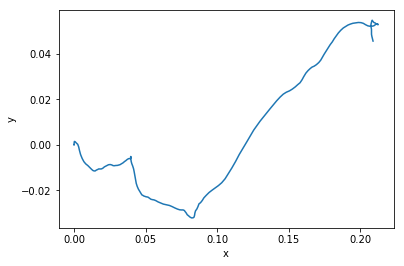

In [27]:
# Put your code here to run the simulation and plot the results
# Don't forget that the values that you need to feed into the function were already defined above!
traj = run_1p_simulation(x0,v0,N,save_int, dt, m , gamma, kT)
plt.plot(traj[:, 0], traj[:, 1])
plt.xlabel("x")
plt.ylabel("y")

### Descriptive analysis (3 points)

Which direction was the particle headed originally?  What happened after that?

It headed up then twisted and started heading down

Now, print out the final position of the particle below:

In [14]:
print(traj[-1])

[ 0.20839989 -0.05520862]


### Running multiple trajectories (10 points)

For this next part, **set the initial velocity (`v0`) to `[0,0]`.**  Then use a loop to run 20 of these trajectories, but only keep track of their final points.

Text(0,0.5,'y')

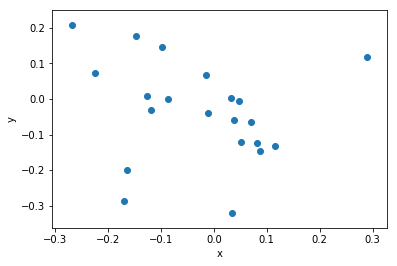

In [42]:
# Put your code here
v0 = np.array([0,0])  
final_pos_arr_x = []
final_pos_arr_y = []
for i in range(21):
    traj = run_1p_simulation(x0,v0,N,save_int, dt, m , gamma, kT)
    final_pos_arr_x.append(traj[-1, 0])
    final_pos_arr_y.append(traj[-1, 1])
plt.scatter(final_pos_arr_x, final_pos_arr_y)
plt.xlabel("x")
plt.ylabel("y")

Once you have your 20 final positions, plot these points on a grid as red circles.

Your image should end up looking something like this (but your points will be in different locations!):

<img src="https://i.imgur.com/EnYEzrz.png">

Compute and print the average final `x` position and the average final `y` position. 

In [45]:
# Put your code here
print("X Average: ", np.mean(final_pos_arr_x), "\nY Average: ", np.mean(final_pos_arr_y))

X Average:  -0.027544705804412938 
Y Average:  -0.03504815095651953


What would you expect these to be, and why?

I'd expect them to be 0 and for all intents and purpoes they were. Since it was random and could be positive or negative, 0 seems like a fair mean

---
## Part 2) Many particles with size exclusion (14 points)

Let's make things a little more exciting and add in a whole bunch of particles!  In this case, the vector $\overrightarrow{x}$ will denote the position not just of one particle, but of many different particles.  We will have $20$ particles in our $2$-dimensional system: so $\overrightarrow{x}$ will be a vector with $40$ elements, and $\overrightarrow{v}$ and $\overrightarrow{R}$ will have $40$ elements as well.  

**But**, if we start adding more particles, we need to make sure they don't overlap.  If you want to get all physics-y about it, you could read up on the [Pauli exclusion principle](https://en.wikipedia.org/wiki/Pauli_exclusion_principle), and [van der Waals radii](https://en.wikipedia.org/wiki/Van_der_Waals_radius).  But today we can just imagine that these are billiard balls (or since we're still in 2D, disks on an air hockey table).

To prevent particles (with a certain radius, $r_0/2$) from overlapping, we need a potential energy curve that looks like this:

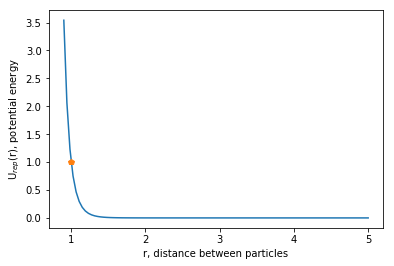

In [46]:
A=1
r0=1

def repel(r):
    Urep = A*(r0/r)**12
    return Urep

r = np.linspace(0.9,5,100)

plt.xlabel('r, distance between particles')
plt.ylabel('U$_{rep}$(r), potential energy')
plt.plot(r,repel(r))
plt.plot(1,r0,'p')  # shows the particle radius
plt.show()

**The $A$ parameter in this potential controls the strength of the repulsion.** This plot indicates that as two particles get closer together the repulsive force between them grows and the closer they are, the stronger that repulsive force is!

In order to use this potential to control how particles move, we actually need the ***gradient of the potential***, which is mathematical term for "the derivative with respect to all of the spatial components."

Let's walk through this:

\begin{equation} U_{rep}(r) = A(r_0/r)^{12} \end{equation}

\begin{equation} \frac{dU_{rep}(r)}{dr} = -12A\frac{r_0^{12}}{r^{13}} \end{equation}

We're almost there!  Remember what our spatial coordinates are: they are our $x$ and $y$ positions for each particle.  So what we *really* need is $\frac{dU_{rep}}{dx_i}$ and $\frac{dU_{rep}}{dy_i}$ (where $i$ denotes the $i$-th particle).  To get those, we can use the fact that the distance between two particles is defined as $r_{ij} = \sqrt{(x_i-x_j)^2 + (y_i-y_j)^2}$ and then we can use the chain rule to get:

\begin{equation} \frac{dU_{rep}}{dx_i} = \frac{dU_{rep}}{dr}\frac{dr}{dx_i} = -12A\frac{r_0^{12}}{r^{13}}\left(\frac{1}{2}\frac{1}{\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2}}2(x_i-x_j)\right) = -12A\frac{r_0^{12}}{r^{14}}(x_i-x_j) \end{equation}

Cutting out the intermediate steps, we have:

\begin{equation} \frac{dU_{rep}}{dx_i} = -12A\frac{r_0^{12}}{r^{14}}(x_i-x_j) \end{equation}

***

Let's make this more formal.  Imagine a system with $N$ particles of radius $r_0/2$, that are all excluded from sharing volume with each other.  The total potential energy of the system is defined as :

\begin{equation} U(\overrightarrow{x}) = \sum_{i=1}^{N-1} \sum_{j=i+1}^N U_{rep}(r_{ij})\end{equation}

and the derivative of all of this with respect to a particular spatial coordinate is:

\begin{equation} \frac{dU(\overrightarrow{x})}{dx_i} = \sum_{j \ne i} \frac{dU_{rep}(r_{ij})}{dx_i} = \sum_{j \ne i} -12A\frac{r_0^{12}}{r_{ij}^{14}}(x_i-x_j) \end{equation}

We are pretty much ready to go!  ***Although let's make one little tweak for the sake of performance***.  As you can see in the plot above, there isn't going to be much of a force between two particles that are far away.  So let's only compute the force if $r_{ij}$ is less than a cutoff, say, $2r_0$.

\begin{equation} \frac{dU(\overrightarrow{x})}{dx_i} = 
\begin{cases}
\sum_{j \ne i} -12A\frac{r_0^{12}}{r_{ij}^{14}}(x_i-x_j) & \text{for } r_{ij} \le 2r_0 \\
0 & \text{for } r_{ij} > 2r_0 \\
\end{cases}
\end{equation}

---

Here are the new update equations, which now includes a $\frac{dU}{dx}$ term that is no longer 0. Note that indexing 2D NumPy array by doing `my_array[i][j]` is the same as doing `my_array[i,j]`.

In [47]:
def updatevel_rep(x,v,dmat,dt,m,gamma,pref,rcutsq,r06,r012,A,B,L):
    # returns the new velocities, given the old acceleration
    # which is the sum of the external forces, a drag term, and a random force
    vnew = v + dt*(-dUdx_rep(x,dmat,rcutsq,r06,r012,A,B,L)/m - gamma*v + pref*rfunc(x.shape))
    return vnew
    
def dUdx_rep(x,dmat,rcutsq,r06,r012,A,B,L):
    # returns the force on each particle in the x and y directions

    npart = len(x)
    f0 = np.zeros_like(x)
    for i in range(npart):
        for j in range(npart):
            if j != i:
                # for each particle j that is not equal to i
                if dmat[i][j] < 2*rcutsq:
                    # ... and is close enough...
                    d14 = dmat[i][j]**7
                    tmp = -12.0*A*r012/d14 
                    f0[i][0] += tmp*peri_dist(x[i][0],x[j][0],L)
                    f0[i][1] += tmp*peri_dist(x[i][1],x[j][1],L)
    return f0

We are also going to run the dynamics using [periodic boundary conditions](https://en.wikipedia.org/wiki/Periodic_boundary_conditions), where if a particle leaves the box through the left boundary, it will reappear through the right boundary.  To implement this we need the following functions:

In [48]:
def peri_dist(x1,x2,L):
    # gets the "x" or "y" distance between two particles given a 
    # periodic box with length L
    d1 = x1-x2
    d2 = x1-x2-L
    d3 = x1-x2+L
    if abs(d1) < abs(d2):
        if abs(d1) < abs(d3):
            return d1
        else:
            return d3
    elif abs(d2) < abs(d3):
        return d2
    else:
        return d3

def getdistancematrix(x,L):
    # returns a matrix of particle-particle distances
    # (this is similar the distance matrix from our traveling salesperson problem!)
    npart = len(x)
    dmat = np.zeros((npart,npart))
    for i in range(npart-1):
        for j in range(i+1,npart):
            d = (peri_dist(x[i][0],x[j][0],L))**2 + (peri_dist(x[i][1],x[j][1],L))**2
            dmat[i][j]=d
            dmat[j][i]=d
    return dmat

def pbc_check(x,L):
    # checks if all particles are in the box
    # if not, it moves them back in
    for i in range(len(x)):
        if x[i][0] < 0:
            x[i][0] += L
        if x[i][0] > L:
            x[i][0] -= L

        if x[i][1] < 0:
            x[i][1] += L
        if x[i][1] > L:
            x[i][1] -= L
    return x

Finally, since we can't just initialize everything at (0,0), and because we don't want our particles to accidentally start on top of each other, we need a good way of initializing our system. The following function makes sure that the particles are randomly distributed and that no particle is on top of another particle.

In [49]:
def setup_positions(npart,rcutsq):
    # returns a set of positions for each particle
    x0 = np.zeros((npart,2))
    for i in range(npart):
        allgood = False
        while (not allgood):
            x0[i] = np.random.random(size=2)

            # check for clashes
            allgood = True
            if i > 0:
                for j in range(i):
                    d = peri_dist(x0[i][0],x0[j][0],L)**2 + peri_dist(x0[i][1],x0[j][1],L)**2
                    if d < 0.6*rcutsq:
                        allgood = False
    return x0

Finally, all of the pieces are put together so that we can run our simulation. The following function takes a set of input values and creates an array of trajectories as the simulation runs. That array, `traj`, is returned by the function.

In [50]:
def run_simulation(N,save_int,dt,kT,m,gamma,npart,r0,A,B,L):
    pref = (2*gamma*kT/m)**(0.5)   # prefactor for random force
                                   # (only compute once and store)

    # we'll be doing these calculations a lot, let's do it once and save it    
    r06 = r0**6
    r012 = r0**12
    rcutsq = 2*r0**2

    # this will record our positions as a function of time
    traj = np.zeros((int(N/save_int),npart,2))

    x0 = setup_positions(npart,rcutsq)   # initial position
    v0 = np.random.normal(loc=0,scale=0.5,size=(npart,2))  # initial velocity

    x = x0
    v = v0

    for step in range(N):
        dmat = getdistancematrix(x,L)  # compute the distance matrix only once per time step
    
        xnew = updatepos(x,v,dt)
        vnew = updatevel_rep(x,v,dmat,dt,m,gamma,pref,rcutsq,r06,r012,A,B,L) 
        x,v = pbc_check(xnew,L),vnew
        
        if step % save_int == 0:
            frame = int(step/save_int)
            traj[frame] = x

        if (step+1)*10 % N == 0:
            pct = int((step+1)*10/N)*10
            print ("%d percent completed" % pct)
            
    return traj

Now we just define our input values, run the simulation, and plot the results!

10 percent completed
20 percent completed
30 percent completed
40 percent completed
50 percent completed
60 percent completed
70 percent completed
80 percent completed
90 percent completed
100 percent completed


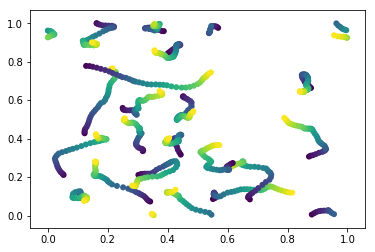

In [51]:
N = 20000     # number of time steps
m = 0.5       # the mass of our particles
kT = 10000.0  # thermal energy
gamma = 10.0  # friction coefficient
dt = 0.00002  # time step
npart = 20    # number of particles
r0 = 0.10     # particle size
L = 1.0       # box size
A = 0.5       # "repulsion" strength
B = 0
save_int = 500  # how often to save the position
traj = run_simulation(N,save_int,dt,kT,m,gamma,npart,r0,A,B,L)

# show all particle trajectories

% matplotlib inline
import matplotlib.pyplot as plt
color=np.array(range(0,int(N/save_int)),dtype='float')
for i in range(npart):
    plt.scatter(traj[:,i,0],traj[:,i,1],c=color,edgecolors='none')
plt.show()

The colors in the plot represent the progression of time! Finally, we can use the following code to make a "movie" of this:

In [52]:
import time
from IPython.display import display,clear_output
% matplotlib inline
import matplotlib.pyplot as plt

def make_traj_movie(traj):

    fig = plt.figure(figsize=(10,10))

    box_x = [0,0,1,1,0]
    box_y = [0,1,1,0,0]
    
    for frame in range(traj.shape[0]):
        plt.plot(box_x,box_y,'k-')
        plt.xlim((-0.1,1.1))
        plt.ylim((-0.1,1.1))
        for i in range(traj.shape[1]):
            plt.scatter(traj[frame,i,0],traj[frame,i,1],s=2000)
        time.sleep(0.1)  
        clear_output(wait = True)
        display(fig)            # Reset display
        fig.clear()             # clear output for animation

In [ ]:
make_traj_movie(traj)

### Run three trajectories with A = 0.1, 0.01 and 0.001 and save them (3 points)

Now that you've run a simulation for the default values, you're going to explore how the simulation results change when you vary the value of $A$. Run **three different** simulations using three different values for $A$ (0.1, 0.01, 0.001) and store the results in three different "traj" variables. 

**Note**: This might take your computer a bit of time to run, so be patient! The simulation should output it's progress so that you can ensure things are still moving along.

In [93]:
# Put your code here
A = [1,.1,.01,.001]
traj1 = run_simulation(N, save_int, dt, kT, m, gamma, npart, r0, A[1], B, L)

traj01 = run_simulation(N, save_int, dt, kT, m, gamma, npart, r0, A[2], B, L)

traj001 = run_simulation(N, save_int, dt, kT, m, gamma, npart, r0, A[3], B, L)

10 percent completed
20 percent completed
30 percent completed
40 percent completed
50 percent completed
60 percent completed
70 percent completed
80 percent completed
90 percent completed
100 percent completed
10 percent completed
20 percent completed
30 percent completed
40 percent completed
50 percent completed
60 percent completed
70 percent completed
80 percent completed
90 percent completed
100 percent completed
10 percent completed
20 percent completed
30 percent completed
40 percent completed
50 percent completed
60 percent completed
70 percent completed
80 percent completed
90 percent completed
100 percent completed


### Visualize them with `make_traj_movie` and record the differences you observe (3 points)

Using your three different "traj" arrays, use the `make_traj_movie` function to visualize the three different simulations and describe the differences you see.

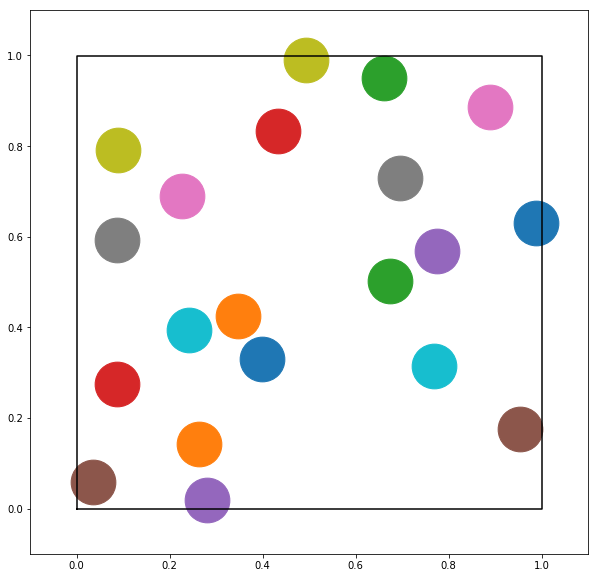

<Figure size 720x720 with 0 Axes>

In [58]:
# Put your code here
make_traj_movie(traj1)

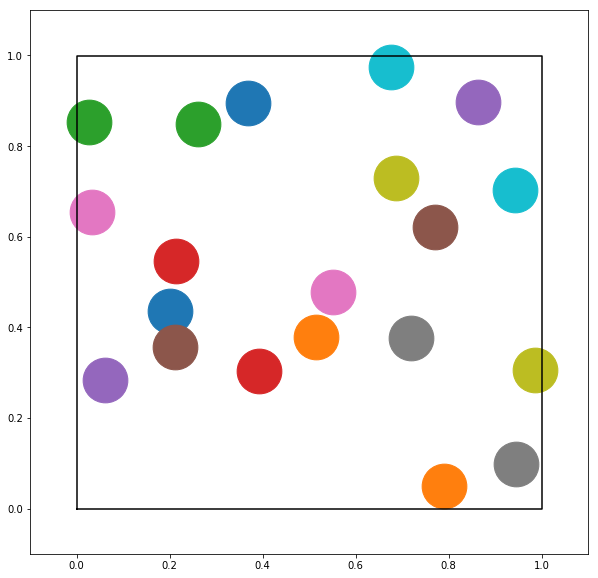

<Figure size 720x720 with 0 Axes>

In [63]:
make_traj_movie(traj01)

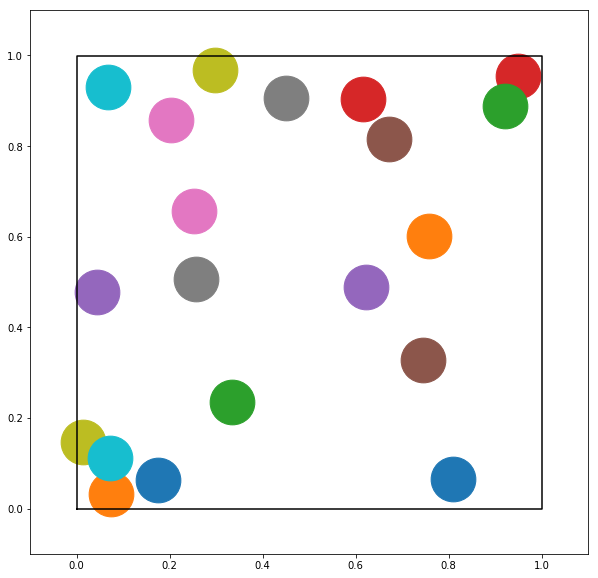

<Figure size 720x720 with 0 Axes>

In [64]:
make_traj_movie(traj001)

The points get closer or farther depending on the A value

### Using the `getdistancematrix` function, get the smallest interparticle distance from each trajectory (5 points)

What if you wanted to know how close any two particles ever ended up in your simulations? You should be able to use your "traj" arrays and the `getdistancematrix` function to step through each of the simulations and find the smallest distance between any two particles at any point in the trajectories. Make sure you store the smallest distances you find for each simulation. 

In [94]:

def func(val, A, traj): 
    for x in range(len(traj)):
        dist_matrix = getdistancematrix(traj[x], L)
        for i in dist_matrix:
            for j in i:
                if j < val: 
                    if j != 0:
                        val = j

    print(f'A = {A}: {val}')
    
    return val
    
val_list = []
val_list.append(func(20, 1, traj))
val_list.append(func(20, .1, traj1))
val_list.append(func(20, .01, traj01))
val_list.append(func(20, .001, traj001))

A = 1: 0.010214440105563334
A = 0.1: 0.007628384980855379
A = 0.01: 0.005374740120359209
A = 0.001: 0.00436411202391291


In [87]:
print(val_list)

[0.010214440105563334, 0.006883323166630723, 0.004659101208772018, 0.0036806727050510387]


### Plot the lowest distance against the value of A (3 points)

Make a plot of the smallest distance versus the value of $A$. Be sure to label the plot, and use a logorithmic scale for the *horizontal axis*. You should get something that looks similar to this:

<img src="https://i.imgur.com/Yareyzi.png">

Text(0,0.5,'Lowest Distance')

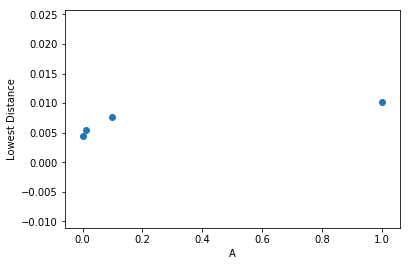

In [102]:
# Put your code here
plt.scatter(A,val_list)
#plt.xscale("log")
plt.xlabel("A")
plt.ylabel("Lowest Distance")

---
## Part 3) Attractive forces (20 points)

Particles often have favorable interactions with each other.  Van der Waals forces (a.k.a. dispersion forces) occur between particles, and are responsible for [keeping rain drops together, and allow a gecko to climb a window](https://en.wikipedia.org/wiki/Van_der_Waals_force).  In this section we're going to add this attractive term into our `dUdx` function and analyze how this affects our dynamics.

The energy function has the following form when we take this new attractive into account:

\begin{equation} U_{LJ}(r) = A\left(\frac{r_0}{r}\right)^{12} - B\left(\frac{r_0}{r}\right)^6 \end{equation}

This is called a **Lennard-Jones Potential**.

### Plot $U_{LJ}$ as a function of r by completing the following function (3 points)

You should compare this function to the `repel` function at the beginning of Part 2. If all goes well, you should end up with something that looks like this:

<img src="https://i.imgur.com/q9q560t.png">

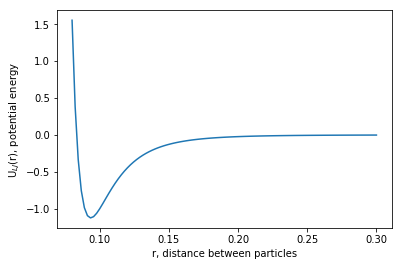

In [106]:
A=0.5
r0=0.1
B=1.5

def LJ(r):
    val = ((A* (r0/r) ** 12) - (B*(r0/r)**6))
    return val# Make sure to return the result!

r = np.linspace(0.08,0.3,100)

plt.xlabel('r, distance between particles')
plt.ylabel('U$_{LJ}$(r), potential energy')
# Uncomment the line below this once you've finished your LJ function
plt.plot(r,LJ(r))
plt.show()

The derivative of this function with respect to $r$ is:

\begin{equation}
\frac{dU_{LJ}}{dr} = -12A\frac{r_0^{12}}{r^{13}} + 6B\frac{r_0^6}{r^7}
\end{equation}

The complete Lennard-Jones potential, involving interactions between all atoms, is given by:

\begin{equation} U(\overrightarrow{x}) = \sum_{i=1}^{N-1} \sum_{j=i+1}^N U_{LJ}(r_{ij})\end{equation}

As above, we must find the derivative of this function with respect to a system coordinate, $x_i$:

\begin{equation} \frac{dU_{LJ}(\overrightarrow{x})}{dx_i} = \sum_{j \ne i} \frac{dU_{LJ}(r_{ij})}{dx_i} = \sum_{j \ne i} \frac{dU_{LJ}(r_{ij})}{dr_ij}\frac{r_{ij}}{dx_{i}} = \sum_{j \ne i} -12A\frac{r_0^{12}}{r_{ij}^{14}}(x_i-x_j) +6B\frac{r_0^{6}}{r_{ij}^{8}}(x_i-x_j) \end{equation}

Without the intermediate steps, this looks like:

\begin{equation} \frac{dU_{LJ}(\overrightarrow{x})}{dx_i} = \sum_{j \ne i} -12A\frac{r_0^{12}}{r_{ij}^{14}}(x_i-x_j) +6B\frac{r_0^{6}}{r_{ij}^{8}}(x_i-x_j) \end{equation}

### Modify the code below to include the extra attractive term (4 points)

This new potential adds another term to the potential we had previously, so we can use our original `dUdx_rep` function from above and add in this new term. Modify the function below to account for this new attractive term. **Hint**: Look at how the `d14` variable is being used to define the `tmp` variable and how these both relate to the mathematical equations for the potential.

In [117]:
def dUdx_rep(x,dmat,rcutsq,r06,r012,A,B,L):
    # returns the force on each particle in the x and y directions

    npart = len(x)
    f0 = np.zeros_like(x)
    for i in range(npart):
        for j in range(npart):
            if j != i:
                # for each particle j that is not equal to i
                if dmat[i][j] < 2*rcutsq:
                    # ... and is close enough...
                    d14 = dmat[i][j]**7
                    d8 = dmat[i][j]**4
                    tmp = -12.0*A*r012/d14  + 6 * B*r06/d8
                    f0[i][0] += tmp*peri_dist(x[i][0],x[j][0],L)
                    f0[i][1] += tmp*peri_dist(x[i][1],x[j][1],L)
    return f0

### Run a trajectory with the parameters below, save it as `traj_LJ` and describe the results (5 points)

Using the variable defined below, run a new simulation and store the result as a new `traj_LJ` variable. Since you've redefined the `dUdx_rep` function to account for the new attractive term, the `run_simulation` function will call your new function and use the new potential!

Once you've run the simulation, run the animation function and describe the results.

In [109]:
# define our constants

m = 0.5      # the mass of our particles
kT = 10000.0     # thermal energy
gamma = 0.1  # friction coefficient
dt = 0.00002  # time step
N = 40000   # number of time steps
npart = 25    # number of particles
r0 = 0.10
L = 1.0
A = 0.5
B = 1.5
save_int = 500  # how often to save the position

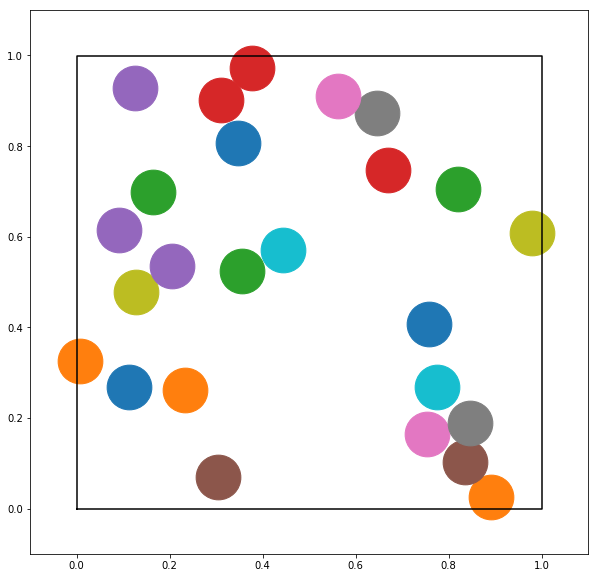

<Figure size 720x720 with 0 Axes>

In [119]:
# Put your code here
traj_LJ = run_simulation(N, save_int, dt,kT, m, gamma, npart, r0, A,B,L)

make_traj_movie(traj_LJ)


// Your answer here

### Using the data stored in the `traj_LJ` array, and the `getdistancematrix` function, plot a histogram of interparticle distances (6 points)

In order to confirm your potential is working as expected, you're going to make a histogram of the interparticle distance. The following hints should help you set up your code to accomplish this task.

Hint #1:  first make a list of distances, then make a histogram using `plt.hist`.

Hint #2:  be sure not to include the distances equal to zero!

Hint #3:  use 50 bins, and a range of [0.05 to 0.25]

Hint #4:  remember the `getdistancematrix` function returns the square of the distances!

Text(0,0.5,'Frequency')

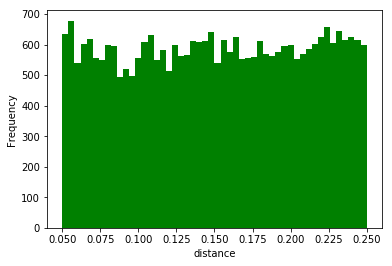

In [127]:
# Put your code here
distLJ = []
## THIS WOULD WORK IF THE OTHER PARTS WORKED 
for x in range(traj_LJ.shape[0]):
    dist_mat = getdistancematrix(traj_LJ[x], L)
    distLJ = np.append(distLJ, dist_mat)
d = distLJ[np.nonzero(distLJ)]
d_actual = d**(1/2)
                
plt.hist(distLJ, bins = 50, range = (.05, .25), color = 'g')
plt.xlabel("distance")
plt.ylabel("Frequency")

### At what distance is the first peak you observe?  Does this make sense?  Why?  (2 points)

Consider the location of the peak in relation the curve for the potential $U_{LJ}$. Two particles are "happiest" when their distance corresponds to the minimum of the $U_{LJ}$ curve. Think about how this relates to the histogram you created!

// Your answer here

---
## Assignment wrap-up

Please fill out the form that appears when you run the code below.  **You must completely fill this out in order to receive credit for the assignment!**

In [115]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://goo.gl/forms/uOKor0ucKhCv52Yc2" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

---

### Congratulations, you're done!

Submit this assignment by uploading it to the course Desire2Learn web page.  Go to the "Homework Assignments" folder, find the submission link for Homework #6, and upload it there.